In [1]:

from sklearnex import patch_sklearn

patch_sklearn()

import matplotlib.pyplot as plt
import numpy as np
import random

from drowsiness_detection.data import (session_type_mapping, load_experiment_objects,
                                       load_preprocessed_train_test_splits,
                                       train_test_split_by_subjects,
                                       get_feature_data, preprocess_feature_data, load_preprocessed_train_val_test_splits)
from drowsiness_detection import config
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

plt.rcParams["figure.figsize"] = 14, 7

MIN_LABELS, MAX_LABELS = 0, 1

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
# %load_ext autoreload
# %autoreload 2
seed = 2
random.seed(seed)
np.random.seed(seed)

In [3]:
experiment_id = 49
exp_config, best_estimator, _ = load_experiment_objects(experiment_id=experiment_id)

window_size = exp_config["window_in_sec"]
config.set_paths(30, window_size)

Create training, validation and test set

In [4]:
X_train, X_test, X_val, y_train, y_test, y_val = load_preprocessed_train_val_test_splits(
    data_path=config.PATHS.WINDOW_FEATURES,
    exclude_sess_type=session_type_mapping[exp_config["exclude_by"]],
    num_targets=exp_config["num_targets"],
    seed=exp_config["seed"],
    test_size=exp_config["test_size"],
    split_by_subjects=True)

Number of samples in training, validation and test data

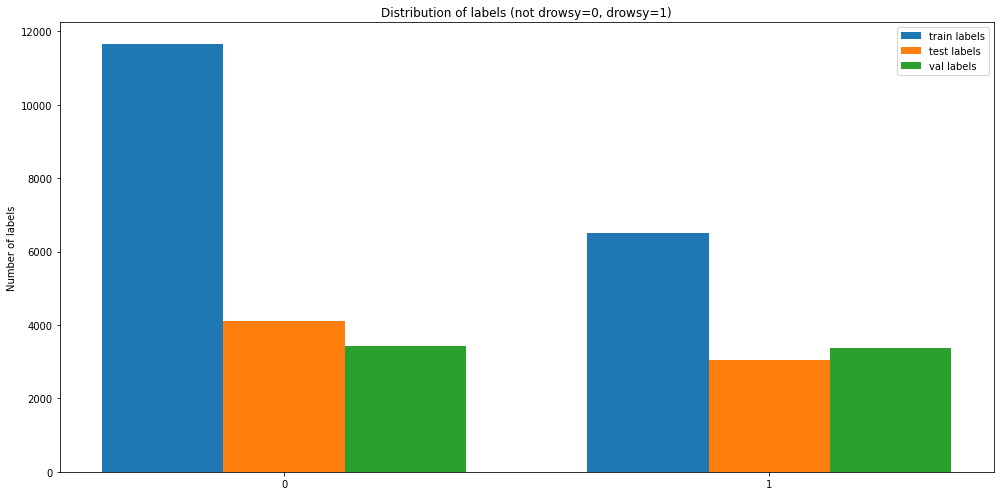

In [5]:
fig, ax = plt.subplots(1, 1)
x = np.array([0, 1])
width = .25
bins = [0, .5, 1]

rects1 = ax.bar(x, np.histogram(y_train, bins=bins)[0], width, label="train labels")
rects2 = ax.bar(x + width, np.histogram(y_test, bins=bins)[0], width, label="test labels")
rects3 = ax.bar(x + width * 2, np.histogram(y_val, bins=bins)[0], width, label="val labels")


ax.set_ylabel("Number of labels")
ax.set_title("Distribution of labels (not drowsy=0, drowsy=1)")
ax.set_xticks(x + width, x)
ax.legend()

fig.tight_layout()
plt.show()

see how subject ids are distributed within splits with different seeds

In [7]:
all_test_ids, all_train_ids = [], []
for _ in range(10):
    data = get_feature_data(data_path=config.PATHS.WINDOW_FEATURES)
    X, y, subject_data = preprocess_feature_data(feature_data=data,
                                   exclude_sess_type=session_type_mapping[exp_config["exclude_by"]],
                                   num_targets=exp_config["num_targets"])
    X_train, X_test, y_train, y_test, (train_ids, test_ids), _ = train_test_split_by_subjects(X, y,
                                                                                           num_targets=
                                                                                           exp_config[
                                                                                               "num_targets"],
                                                                                           test_size=
                                                                                           exp_config[
                                                                                               "test_size"], subject_data=subject_data)
    all_train_ids.append(train_ids)
    all_test_ids.append(test_ids)

In [8]:
def compare_data_splits(all_ids):
    same_counts = []
    for train_ids1 in all_ids:
        for train_ids2 in all_ids:
            if np.array_equal(train_ids1, train_ids2):
                continue
            same_count = 0
            for train_id in train_ids1:
                if train_id in train_ids2:
                    same_count += 1
            same_counts.append(same_count / len(train_ids1))
    return same_counts


print(
    f"on average there were {np.mean(compare_data_splits(all_train_ids))} of ids in the other training sets")
print(
    f"on average there were {np.mean(compare_data_splits(all_test_ids))} of ids in the other test sets")


on average there were 0.7839681418112789 of ids in the other training sets
on average there were 0.22354096520763184 of ids in the other test sets


Experiment with splitting of dataset


In [ ]:
classifier = RandomForestClassifier(criterion="entropy",
                                    max_depth=80,
                                    max_features="sqrt",
                                    n_estimators=512,
                                    class_weight="balanced",
                                    n_jobs=-2,
                                    min_samples_split=0.01
                                    )
scaler = StandardScaler()
pipe = make_pipeline(scaler, classifier)

In [ ]:
pipe.fit(X_train, y_train)


In [ ]:
print(f"train score: {pipe.score(X_train, y_train)}")
print(f"test score: {pipe.score(X_test, y_test)}")


Testing different hyperparameters to improve train score with seed 2:
max samples: 0.6
train score: 0.7468598103854853
test score: 1.0

max samples: 0.2
train score: 0.7334327927234227
test score: 0.9955974288984767

-> max samples not so effective to improve generalization

min samples split reduces train score -> better generalization?
test the above on different window sizes:
10 sec:
train score: 0.88226737779345
test score: 0.8298574764473791

20 sec:
train score: 0.8819999117426416
test score: 0.8738503079908868

60 sec:
train score: 0.9486186298301288
test score: 0.7993089279043706

Testing different seed for splitting data by subjects:

seed 123:
[(20782, 787), (20782,), (11354, 787), (11354,)]
train score: 0.7130690020209797
test score: 1.0

seed 42:
[(21421, 787), (21421,), (10715, 787), (10715,)]
train score: 0.7201811306661687
test score: 1.0

seed 1:
[(21105, 787), (21105,), (11031, 787), (11031,)]
train score: 0.7194029850746269
test score: 1.0

seed 2:
[(20779, 787), (20779,), (11357, 787), (11357,)]
train score: 0.7597093219115453
test score: 1.0

--> yields very similar results